# Tripadvisor 투어 리뷰 데이터 분석

## 파일 및 라이브러리 불러오기

In [1]:
# 필요 라이브러리 호출
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import re
from wordcloud import WordCloud
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore")

C:\Users\Chanseo Park\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# 시각화를 위한 폰트설정
import matplotlib.pyplot as plt
font_family = 'Malgun Gothic'
plt.rc("font", family=font_family)
plt.rc("axes", unicode_minus=False)
plt.style.use("ggplot")

In [3]:
# 크롤링 완료 파일 불러오기
df = pd.read_excel('./t_scraped/all_reviews_final.xlsx')
df.head()

tour_title  \
0  1.Ultimate DMZ & JSA: Private Tour along North...   
1  1.Ultimate DMZ & JSA: Private Tour along North...   
2  1.Ultimate DMZ & JSA: Private Tour along North...   
3  1.Ultimate DMZ & JSA: Private Tour along North...   
4  1.Ultimate DMZ & JSA: Private Tour along North...   

                                 review_title  \
0                                 A great day   
1                        Pleasant and private   
2  Amazing experience! Highlight of our trip.   
3       Fantastic tour with incredible guide!   
4                              Pretty awesome   

                                      review_comment  \
0  Our guide Shrek was unbelievably friendly and ...   
1  My wife and have attended many outings with a ...   
2  Our tour guide was fantastic. Very friendly an...   
3  My wife and I really enjoyed our first visit t...   
4  The highlight was the JSA tour which was super...   

                          review_date  review_score  \
0    Date of experience: January 2020             5   
1   Date of experience: December 2019             5   
2  Date of experience: September 2019             5   
3    Date of experience: October 2019             5   
4       Date of experience: June 2019             5   

                         trip_type  
0  Trip type: Traveled as a couple  
1                              NaN  
2                              NaN  
3                              NaN  
4                              NaN

In [4]:
# 컬럼별 dtype 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3381 entries, 0 to 3380
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tour_title      3381 non-null   object
 1   review_title    3381 non-null   object
 2   review_comment  3381 non-null   object
 3   review_date     2552 non-null   object
 4   review_score    3381 non-null   int64 
 5   trip_type       1987 non-null   object
dtypes: int64(1), object(5)
memory usage: 158.6+ KB


In [5]:
print('분석 대상:')
print(f'{df.tour_title.nunique()}개 투어 프로그램')
print(f'{df.review_title.count()}개 리뷰')
print('')
print('분석 기간:')
print(f'{df.review_date.nunique()}개월')

분석 대상:
144개 투어 프로그램
3381개 리뷰

분석 기간:
72개월


In [6]:
# 컬럼별 unique값 확인
for col in df.columns:
    print(f"Column명: {col}")
    print(f"Unique값: {df[col].nunique()}")
    print()

Column명: tour_title
Unique값: 144

Column명: review_title
Unique값: 3070

Column명: review_comment
Unique값: 3381

Column명: review_date
Unique값: 72

Column명: review_score
Unique값: 5

Column명: trip_type
Unique값: 5



## 결측치 처리

In [7]:
# review_date, trip_type 컬럼에 결측치 존재
# trip_type은 결측치 대체할 방법이 없음
df.isnull().sum()

tour_title           0
review_title         0
review_comment       0
review_date        829
review_score         0
trip_type         1394
dtype: int64

In [9]:
# 투어 프로그램 하나를 선정하여 review_date가 결측치인 데이터의 앞뒤 review_date 확인
# 연속성이 없거나 여러 데이터가 연속으로 결측치인 경우도 존재하여 특정 값으로 대체하지는 않기로 함
# review_date이 결측치인 데이터는 긍정/부정 리뷰 분석에는 포함, 연도별 분석에는 미포함 하기로 함

df_temp = df[df['tour_title'].str.contains('Ultimate DMZ')]
review_date_null = df_temp[df_temp['review_date'].isnull()].index.tolist()
for i in review_date_null:
    pre_con = df_temp.loc[i-2:i+2, 'review_date']
    print(pre_con)

4         Date of experience: June 2019
5    Date of experience: September 2019
6                                   NaN
7    Date of experience: September 2019
8       Date of experience: August 2019
Name: review_date, dtype: object
15    Date of experience: May 2019
16    Date of experience: May 2019
17                             NaN
18    Date of experience: May 2019
19    Date of experience: May 2019
Name: review_date, dtype: object
21    Date of experience: April 2019
22    Date of experience: April 2019
23                               NaN
24    Date of experience: March 2019
25                               NaN
Name: review_date, dtype: object
23                               NaN
24    Date of experience: March 2019
25                               NaN
26                               NaN
27                               NaN
Name: review_date, dtype: object
24    Date of experience: March 2019
25                               NaN
26                               NaN
27          

## 필요 컬럼 생성

In [53]:
# trip_type 컬럼은 여행 타입 파악에 필요한 단어만 남김
df['trip_type'] = df['trip_type'].str.split(' ').str[-1]
df.head()

tour_title  \
0  1.Ultimate DMZ & JSA: Private Tour along North...   
1  1.Ultimate DMZ & JSA: Private Tour along North...   
2  1.Ultimate DMZ & JSA: Private Tour along North...   
3  1.Ultimate DMZ & JSA: Private Tour along North...   
4  1.Ultimate DMZ & JSA: Private Tour along North...   

                                 review_title  \
0                                 A great day   
1                        Pleasant and private   
2  Amazing experience! Highlight of our trip.   
3       Fantastic tour with incredible guide!   
4                              Pretty awesome   

                                      review_comment  \
0  Our guide Shrek was unbelievably friendly and ...   
1  My wife and have attended many outings with a ...   
2  Our tour guide was fantastic. Very friendly an...   
3  My wife and I really enjoyed our first visit t...   
4  The highlight was the JSA tour which was super...   

                          review_date  review_score trip_type  year  \
0    Date of experience: January 2020             5    couple  2020   
1   Date of experience: December 2019             5       NaN  2019   
2  Date of experience: September 2019             5       NaN  2019   
3    Date of experience: October 2019             5       NaN  2019   
4       Date of experience: June 2019             5       NaN  2019   

       month   yearmonth positive  
0    January  2020-01-01        y  
1   December  2019-12-01        y  
2  September  2019-09-01        y  
3    October  2019-10-01        y  
4       June  2019-06-01        y

In [54]:
# review_date의 연도, 월 정보 추출하여 yearmonth에 저장
df['year'] = df['review_date'].str.split(' ').str[4]
df['month'] = df['review_date'].str.split(' ').str[3]
df['yearmonth'] = df['year'] + '-' + df['month']
df['yearmonth'] = pd.to_datetime(df['yearmonth'], format = '%Y-%B').dt.date
df.head()

tour_title  \
0  1.Ultimate DMZ & JSA: Private Tour along North...   
1  1.Ultimate DMZ & JSA: Private Tour along North...   
2  1.Ultimate DMZ & JSA: Private Tour along North...   
3  1.Ultimate DMZ & JSA: Private Tour along North...   
4  1.Ultimate DMZ & JSA: Private Tour along North...   

                                 review_title  \
0                                 A great day   
1                        Pleasant and private   
2  Amazing experience! Highlight of our trip.   
3       Fantastic tour with incredible guide!   
4                              Pretty awesome   

                                      review_comment  \
0  Our guide Shrek was unbelievably friendly and ...   
1  My wife and have attended many outings with a ...   
2  Our tour guide was fantastic. Very friendly an...   
3  My wife and I really enjoyed our first visit t...   
4  The highlight was the JSA tour which was super...   

                          review_date  review_score trip_type  year  \
0    Date of experience: January 2020             5    couple  2020   
1   Date of experience: December 2019             5       NaN  2019   
2  Date of experience: September 2019             5       NaN  2019   
3    Date of experience: October 2019             5       NaN  2019   
4       Date of experience: June 2019             5       NaN  2019   

       month   yearmonth positive  
0    January  2020-01-01        y  
1   December  2019-12-01        y  
2  September  2019-09-01        y  
3    October  2019-10-01        y  
4       June  2019-06-01        y

In [18]:
# review_score 4점 이상 긍정 리뷰는 p, 3점 이하 부정 리뷰는 n으로 라벨링
df.loc[df['review_score']>=4, 'positive'] = 'y'
df.loc[df['review_score']<=3, 'positive'] = 'n'
df.head(1)

tour_title review_title  \
0  1.Ultimate DMZ & JSA: Private Tour along North...  A great day   

                                      review_comment  \
0  Our guide Shrek was unbelievably friendly and ...   

                        review_date  review_score  \
0  Date of experience: January 2020             5   

                         trip_type  year    month   yearmonth positive  
0  Trip type: Traveled as a couple  2020  January  2020-01-01        y

## EDA

In [11]:
# 2014-03부터 2021-02까지 72개월치 데이터 존재
df['yearmonth'].describe()

count           2552
unique            72
top       2019-08-01
freq             217
Name: yearmonth, dtype: object

### 리뷰건수 및 리뷰점수

In [55]:
# 연월별 총 리뷰건수 및 리뷰점수 평균 확인
temp = df[['year', 'month', 'yearmonth','review_score']].copy()
temp = temp.groupby('yearmonth')['year', 'month', 'review_score'].agg(
    {'year':'max', 'month':'max', 'review_score': ['mean', 'count']})
temp = temp.reset_index().sort_values(by = ('year', 'max'))
temp

yearmonth  year     month review_score      
                 max       max         mean count
0   2014-03-01  2014     March     5.000000     2
1   2014-06-01  2014      June     5.000000     1
2   2014-08-01  2014    August     5.000000     1
3   2014-10-01  2014   October     5.000000     2
4   2015-02-01  2015  February     5.000000     2
..         ...   ...       ...          ...   ...
60  2020-02-01  2020  February     4.976190    42
59  2020-01-01  2020   January     4.967033    91
70  2020-12-01  2020  December     5.000000     1
64  2020-06-01  2020      June     5.000000     1
71  2021-02-01  2021  February     5.000000     2

[72 rows x 5 columns]

<AxesSubplot:xlabel='yearmonth', ylabel="('review_score', 'count')">

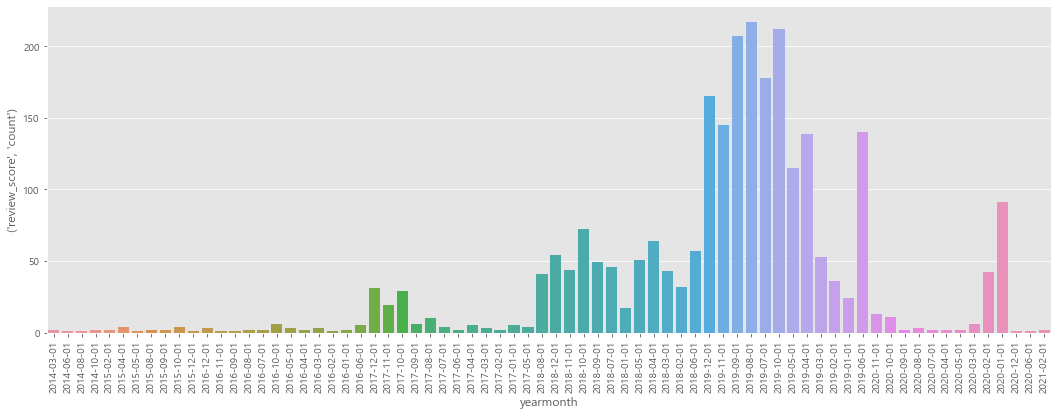

In [56]:
# 연월별 리뷰건수 그래프
plt.figure(figsize=(18,6))
plt.xticks(rotation = 90)
sns.barplot(data = temp, x = 'yearmonth', y = ('review_score', 'count'))

<AxesSubplot:xlabel='yearmonth', ylabel="('review_score', 'mean')">

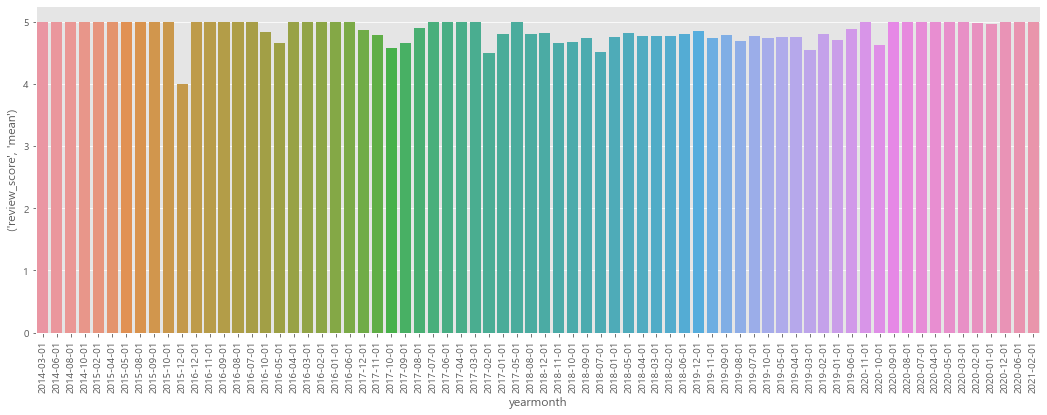

In [61]:
# 연월별 평균 리뷰점수 그래프
plt.figure(figsize=(18,6))
plt.xticks(rotation = 90)
sns.barplot(data = temp, x = 'yearmonth', y = ('review_score', 'mean'))

In [58]:
# 연도별 리뷰건수 확인
# 추후 리뷰개수가 폭발적으로 증가한 2019년을 기준으로 전후 리뷰 텍스트 데이터를 비교하기로 함
df.groupby('year')['month'].agg('count').reset_index().rename(columns = {'month' : 'count'})

year  count
0  2014      6
1  2015     16
2  2016     31
3  2017    120
4  2018    570
5  2019   1631
6  2020    176
7  2021      2

### 긍정, 부정 리뷰수

In [20]:
# 연도별 긍정, 부정 리뷰수 확인
# 부정 리뷰는 2017~2020 구간에만 존재
temp2 = df.groupby(['year', 'positive']).size().reset_index().rename(columns = {0 : 'count'}).sort_values(by = 'year')
temp2

year positive  count
0   2014        y      6
1   2015        y     16
2   2016        y     31
3   2017        n      5
4   2017        y    115
5   2018        n     33
6   2018        y    537
7   2019        n     75
8   2019        y   1556
9   2020        n      2
10  2020        y    174
11  2021        y      2

<AxesSubplot:xlabel='year', ylabel='count'>

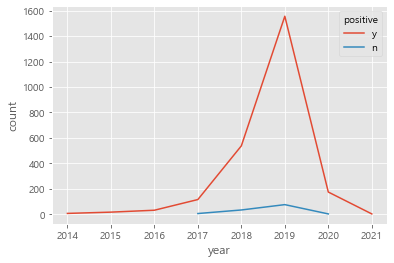

In [60]:
# 연도별 긍정, 부정 리뷰수 그래프
# 2017-2019 구간에서 긍정리뷰 증가세가 부정리뷰 증가세 대비 압도적으로 가파름
sns.lineplot(x = 'year', y = 'count', data = temp2, hue = 'positive')

### Tour_title별 분석

In [27]:
# 리뷰수 기준 상위 투어
# DMZ 투어, 서울 내 이색 체험 투어가 상위권에 포진
df.groupby('tour_title')['review_score'].agg(['count', 'mean']).sort_values(by = 'count', ascending = False).head(20)

count      mean
tour_title                                                         
Half-Day Korean DMZ Tour from Seoul                   230  4.491304
Traditional Cooking Experience in Korean Style ...    182  4.978022
Small-Group Korean Night Food Tour                    162  4.864198
Full-Day Essential Seoul Tour                         144  4.743056
Korean Cooking Class with Full-Course Meal & Lo...    132  4.977273
Jeju East Course - (Lunch included) Bus Tour, F...    126  4.769841
Evening Ghost Walking Tour in Seoul                   126  4.952381
Korean Demilitarized Zone (DMZ) Half-Day Tour f...    121  4.190083
Seoul Pub Crawl and Party with Free Shots              93  4.935484
Traditional Korean Cooking Class (Kimchi) & mar...     86  4.976744
Jeju West Course - (Lunch included) Bus Tour, F...     86  4.732558
Seoul City Private Full-Day Tour Including Lunch       80  5.000000
DMZ Small Group Tour from Seoul Including Dora ...     79  4.468354
Small-Group Korean Cooking Class in Seoul              73  4.945205
No Shopping DMZ Half Day Tour from Seoul               69  4.637681
Small Group Busan Highlight Tour                       68  4.955882
Seoul Private Flexible Adventure Tour                  64  4.937500
Drinking and Eating through the Alleys of Seoul        60  4.983333
Central Seoul Tour                                     59  4.983051
Historic Jongro District Authentic Food Tour in...     55  4.872727

In [31]:
# 평균 평점 기준 상위 투어 (리뷰수 10 이상만 조회)
# 평균 평점이 5점인 투어 중 부산, 제주, 경기권 등 비서울 투어가 다수 포진
temp_score = df.groupby('tour_title')['review_score'].agg(['count', 'mean']).sort_values(by = 'mean', ascending = False)
temp_score[temp_score['count']>10].head(20)

count      mean
tour_title                                                         
 Private Tour Nami Island with Petite France or...     11  5.000000
Highlights & Hidden Gems With Locals: Best of S...     13  5.000000
Seoul City Private Full-Day Tour Including Lunch       80  5.000000
Pocheon Private Day Tour from Seoul Including L...     13  5.000000
Private Busan Highlight Tour with Gamcheon Cult...     12  5.000000
Fully Customizable Private Tour of Jeju Island         29  5.000000
Cruise Layover: Full-day Customizable Private B...     13  5.000000
Day Trip to Petit France, Nami Island and Elysi...     28  5.000000
Full Day Korean DMZ Tour including the War Memo...     13  5.000000
Bangtan Boys Film Location Private Day Trip            18  5.000000
Full Day- Essential Seoul City Tour & Gourmet T...     11  5.000000
Drinking and Eating through the Alleys of Seoul        60  4.983333
Central Seoul Tour                                     59  4.983051
Traditional Cooking Experience in Korean Style ...    182  4.978022
Korean Cooking Class with Full-Course Meal & Lo...    132  4.977273
Traditional Korean Cooking Class (Kimchi) & mar...     86  4.976744
Immersive Korean BBQ, Market, and Secret Pub Ex...     35  4.971429
3-Hour Small Group Korean Pub Crawl + Food Tast...     28  4.964286
Private DMZ Peace Tour : N.Korea 3rd Invasion T...     25  4.960000
Fully Customizable Private Tour From Seoul to G...     47  4.957447

In [64]:
# 평균 평점 기준 하위 투어 (리뷰수 3 이상만 조회)
# 평균 평점 4점 미만인 투어 중 80%가 DMZ 관련
temp_score[temp_score['count']>3].tail(20)

count      mean
tour_title                                                         
Full-Day Palace Tour in Seoul                          21  4.666667
Seoul City Sightseeing Tour Including Gyeongbok...     17  4.647059
No Shopping DMZ Half Day Tour from Seoul               69  4.637681
Gyeongju Small Group One Day Tour from Busan (M...     22  4.545455
[Premium Private Tour] Mt Seorak & East Sea or ...      4  4.500000
5-Day South Korean Cities Tour from Seoul Inclu...      4  4.500000
Half-Day Korean DMZ Tour from Seoul                   230  4.491304
DMZ Small Group Tour from Seoul Including Dora ...     79  4.468354
Gyeongbokgung Palace Hanbok Rental Experience i...     21  4.428571
The 10 Tastings of Seoul With Locals: Private S...     11  4.363636
Suwon Hwaseong Fortress and Korean Folk Village...      7  4.285714
No Shopping Half Day Korea DMZ Tour                     4  4.250000
Han River private yacht tour                            5  4.200000
Korean Demilitarized Zone (DMZ) Half-Day Tour f...    121  4.190083
K-Fan K-Pop Tour With Lunch Option                      4  4.000000
DMZ Past and Present: Korean Demilitarized Zone...      7  3.714286
Half Day DMZ Tour (No Forced Shopping)                  7  3.714286
Half-Day DMZ - Demilitarized Zone-Infiltration ...     17  3.352941
JSA & DMZ Tour(Tue-Fri)                                23  3.304348
Seoul Hop-On Hop-Off Downtown Palace Course            22  3.045455

### Trip_type별 분석

In [72]:
# trip_type이 결측치가 아닌 데이터 분석
df_triptype = df[df['trip_type'].notnull()]
temp_triptype = df_triptype.groupby('trip_type')['review_score'].agg(['count','mean']).reset_index()
temp_triptype

trip_type  count      mean
0  business     33  4.575758
1    couple    522  4.756705
2    family    456  4.826754
3   friends    500  4.814000
4      solo    476  4.796218

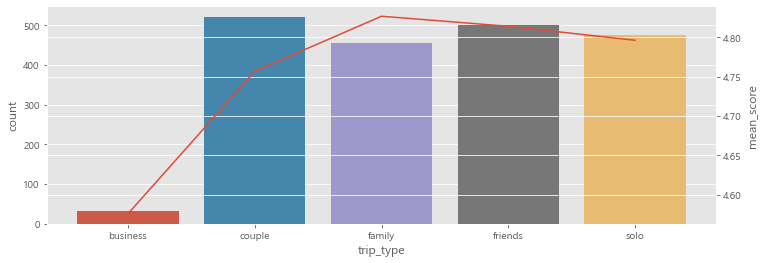

In [76]:
# trip_type별 리뷰건수, 평균 리뷰점수 그래프
# 커플 단위 여행객이 가장 많고 비즈니스 여행객이 가장 적음
# 가족 단위 여행객 평균 리뷰점수가 가장 높고 비즈니스 여행객 점수가 가장 낮음

fig, ax1 = plt.subplots(figsize = (12,4))
ax1.set_xlabel('trip_type')
ax1.set_ylabel('review_count')
ax1 = sns.barplot(x = 'trip_type', y = 'count', data = temp_triptype)
ax1.tick_params(axis = 'y')

ax2 = ax1.twinx()
ax2.set_ylabel('mean_score')
ax2 = sns.lineplot(x = 'trip_type', y = 'mean', data = temp_triptype, sort=False)
ax2.tick_params(axis = 'y')

plt.show()

## 리뷰 텍스트 분석

### 전처리

In [ ]:
# 4점 이상 긍정 리뷰, 3점 이하 부정 리뷰로 분리
positive_review = df[df['review_score']>=4]
negative_review = df[df['review_score']<=3]

In [22]:
# review_comment를 문장 단위로 분리

df_review = df['review_comment'].reset_index()

sentences = []
for row in df_review.itertuples():
    for sentence in sent_tokenize(row[2]):
        sentences.append((row[1], sentence))
new_df = pd.DataFrame(sentences, columns=['ID', 'Comment'])
new_df

ID                                            Comment
0         0  Our guide Shrek was unbelievably friendly and ...
1         0  Enjoyed tour tremendously even though the JSA ...
2         0  Shrek was very accommodating to my wife’s diet...
3         0                                Highly recommended.
4         1  My wife and have attended many outings with a ...
...     ...                                                ...
19489  3380  Chance was very knowledgeable and helped us en...
19490  3380                       The food was also excellent!
19491  3380            The van was very comfortable and clean.
19492  3380  Moreover, we were able to see the beautiful sc...
19493  3380  Overall, the tour was fantastic and quite refr...

[19494 rows x 2 columns]

### 불용어 정의

In [23]:
# 불용어 정의
stops = set(stopwords.words('english')).union(drops)
drops = set(['tour', 'trip', 'day', 'korean', 'korea', 'etc', 'also', 'even', 'since', 'around', 'really', 'definitely','would',
            'good', 'great', 'best', 'went', 'one', 'two', 'well', 'happy', 'told', 'like', 'quite', 'got', 'yes', 'booked', 'meet',
            'days', 'knew', 'highly', 'recommend', 'time', 'make', 'tours', 'took', 'see', 'fun', 'made', 'much', 'place', 'lot',
            'places', 'way', 'amazing', 'interesting', 'nice', 'enjoyed', 'visit', 'excellent', 'get', 'back', 'first', 'many', 
             'could', 'gave', 'take', 'everything', 'thank', 'north', 'south', 'visited', 'thanks','able', 'want', 'worth', 'enough',
             'easy', 'perfect', 'super', 'things', 'sure','full', 'never', 'fantastic', 'provided', 'stop', 'kind', 'little',
            'bit', 'every', 'met', 'loved', 'along', 'going', 'overall', 'anyone', 'felt', 'next', 'everyone', 'always',
            'still', 'lots', 'least', 'finally', 'tons', 'either', 'speaks', 'mentioned'])
shortword = re.compile(r'\W*\b\w{1,2}\b')

### 함수 정의

In [24]:
# 워드클라우드 함수
def wordcloud(data, width=1200, height=700):
    word_draw = WordCloud(
       relative_scaling=1,
        width=width, height=height,
        background_color="white",
        random_state=42
    )
    word_draw.generate(data)

    plt.figure(figsize=(15, 7))
    plt.imshow(word_draw)
    plt.axis("off")
    plt.show()

In [25]:
# 단어 수 함수
def wordcount(data):
    p_count = pd.Series(data.split(",")).value_counts()
    plt.figure(figsize=(15,6))
    return p_count[:50].plot(kind = 'bar')

In [26]:
# 연도별 워드클라우드, 단어 수 리턴 함수
def yearly_wordcount(data, year) :
    p = data[data['year'] == year]
    p_comment = str(p["review_comment"].tolist())

    p_comment = re.sub('[^a-zA-Z]', ' ', p_comment)
    p_comment = re.sub("  {2,}", " ", p_comment).lower()

    p_comment = shortword.sub('', p_comment)
    p_words = p_comment.split()
    p_words = [w for w in p_words if not w in stops]
    p_comment = str(p_words).replace("'","").replace(" ","")
    
    p_count = pd.Series(p_comment.split(",")).value_counts()

    return wordcloud(p_comment), wordcount(p_comment)

In [27]:
# 연도별 리뷰 코멘트 리턴 함수
def yearly_wordcount_data(data, year) :
    p = data[data['year'] == year]
    p_comment = str(p["review_comment"].tolist())

    p_comment = re.sub('[^a-zA-Z]', ' ', p_comment)
    p_comment = re.sub("  {2,}", " ", p_comment).lower()

    p_comment = shortword.sub('', p_comment)
    p_words = p_comment.split()
    p_words = [w for w in p_words if not w in stops]
    p_comment = str(p_words).replace("'","").replace(" ","")
     
    return p_comment

### 연도별 워드클라우드 및 단어분포

#### Positive review 결과 확인

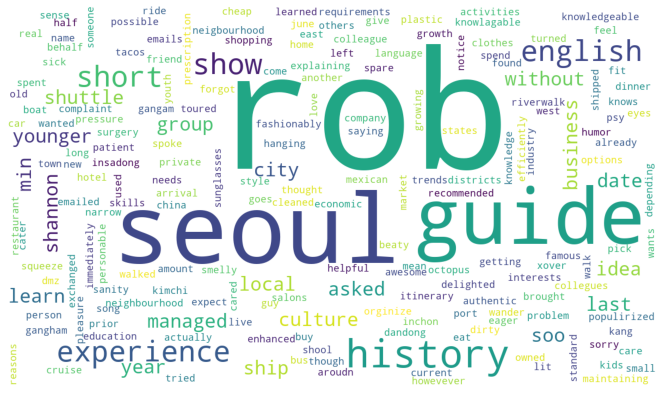

(None, <AxesSubplot:>)

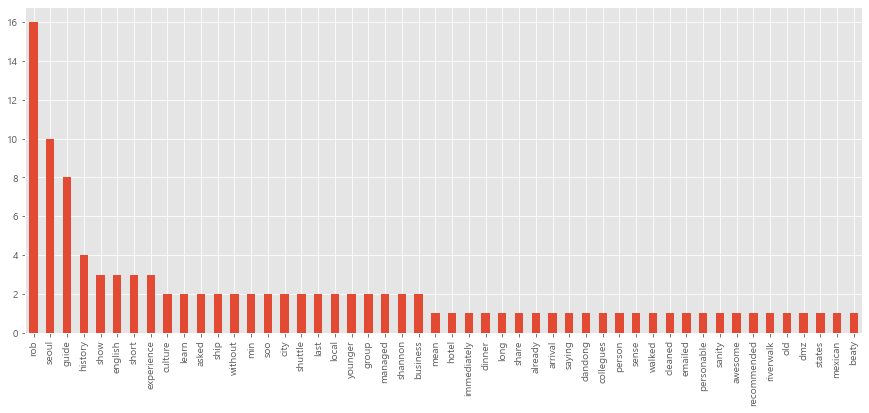

In [28]:
yearly_wordcount(positive_review, '2014')

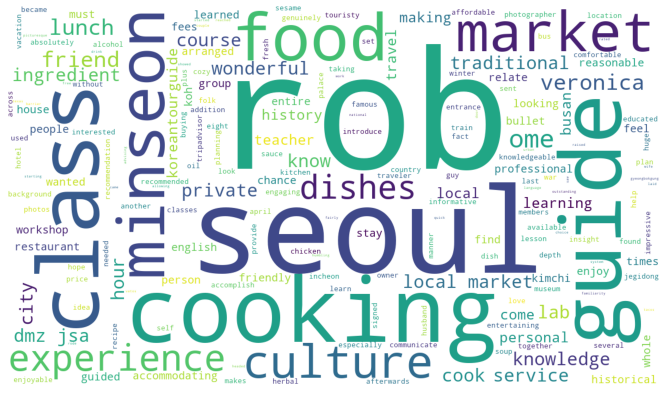

(None, <AxesSubplot:>)

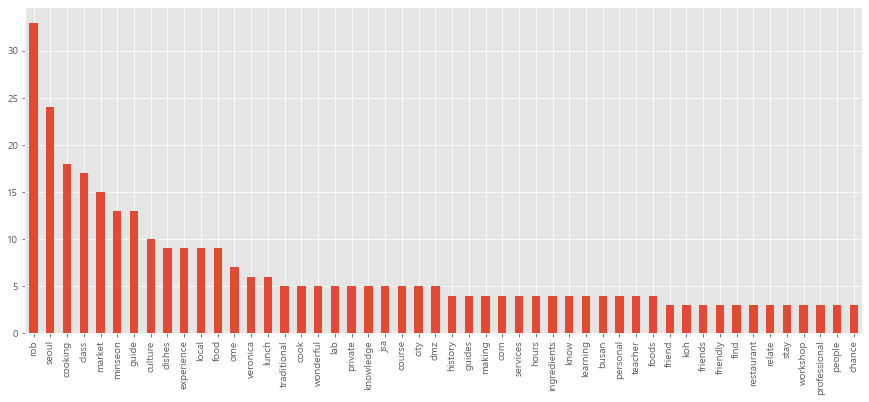

In [29]:
yearly_wordcount(positive_review, '2015')

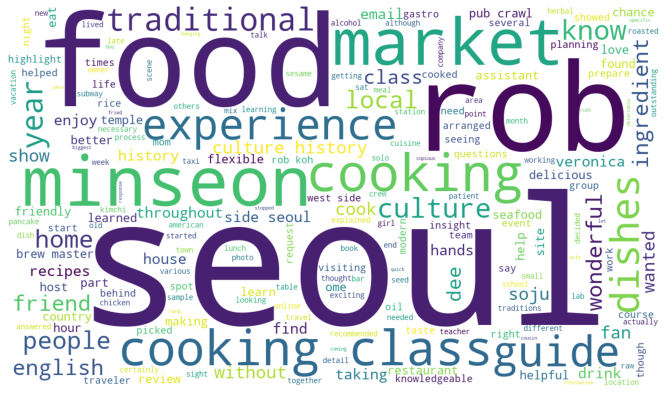

(None, <AxesSubplot:>)

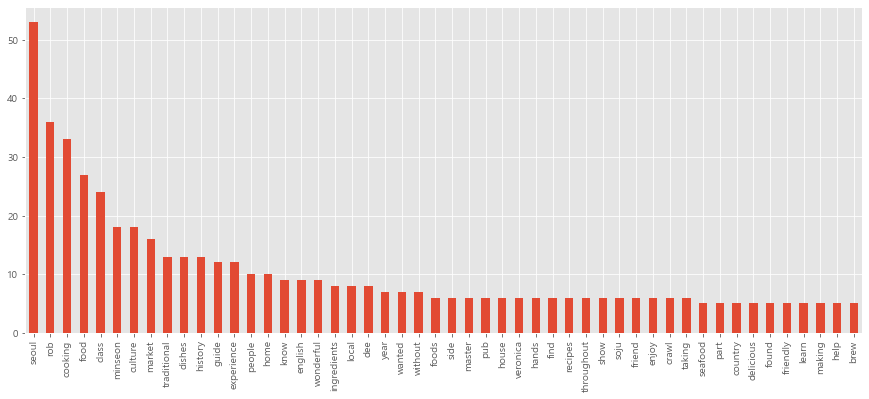

In [30]:
yearly_wordcount(positive_review, '2016')

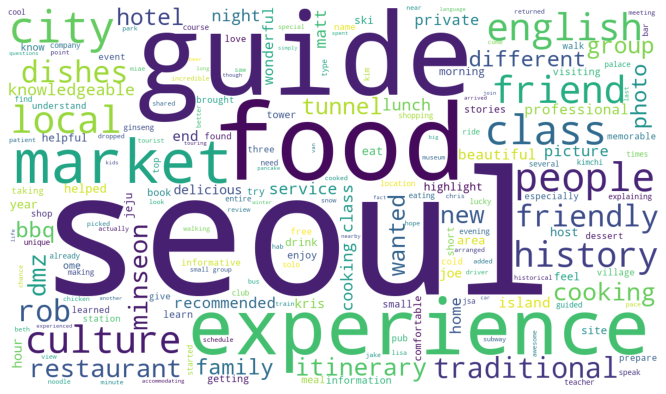

(None, <AxesSubplot:>)

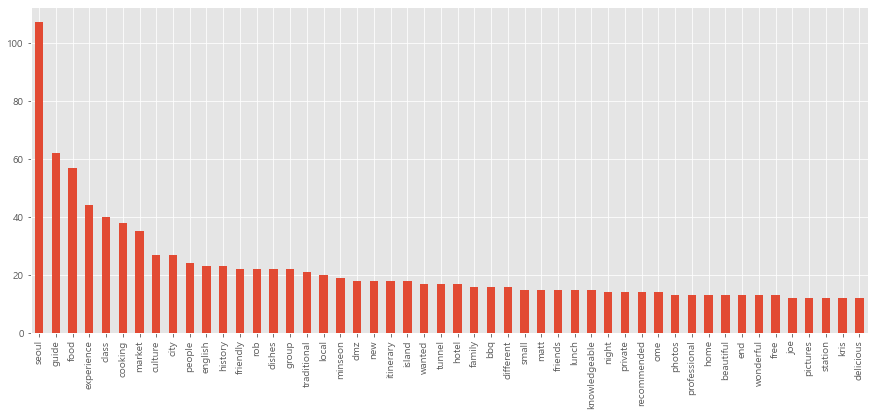

In [31]:
yearly_wordcount(positive_review, '2017')

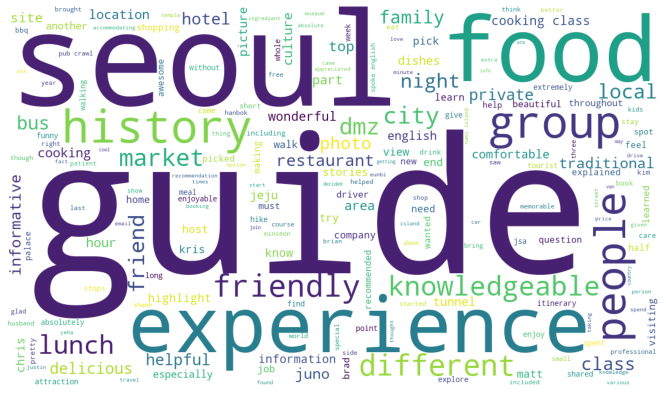

(None, <AxesSubplot:>)

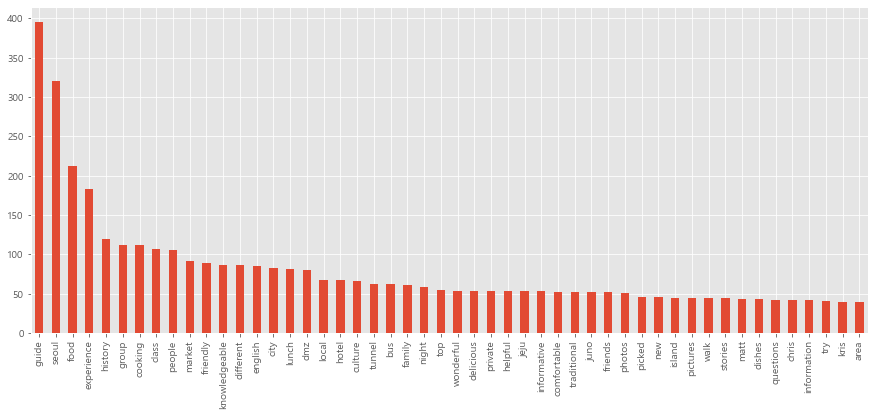

In [32]:
yearly_wordcount(positive_review, '2018')

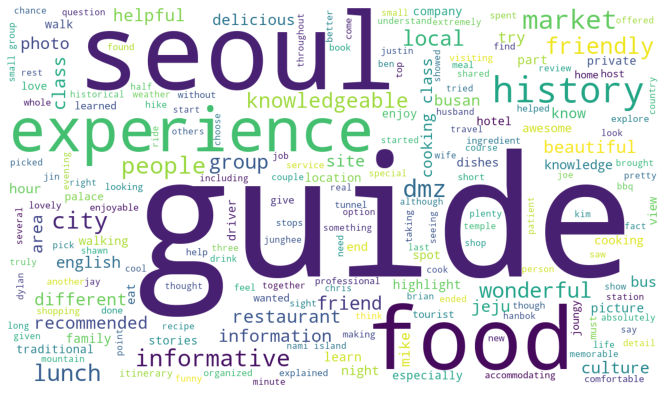

(None, <AxesSubplot:>)

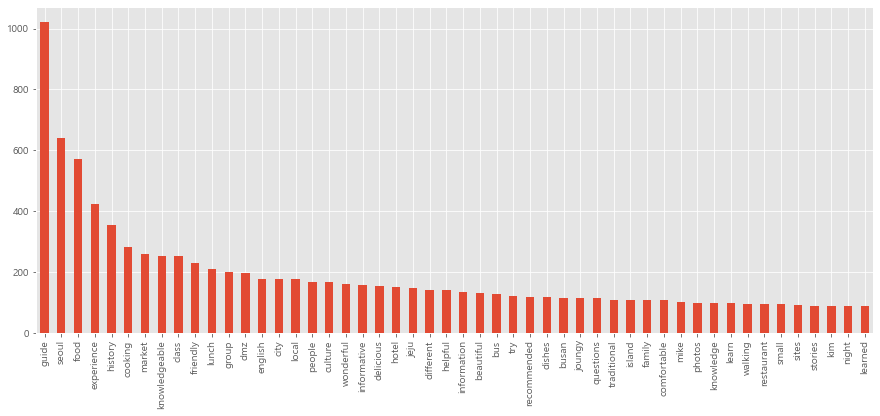

In [33]:
yearly_wordcount(positive_review, '2019')

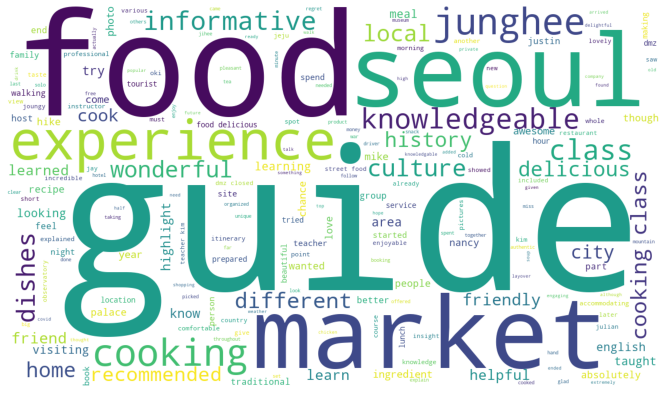

(None, <AxesSubplot:>)

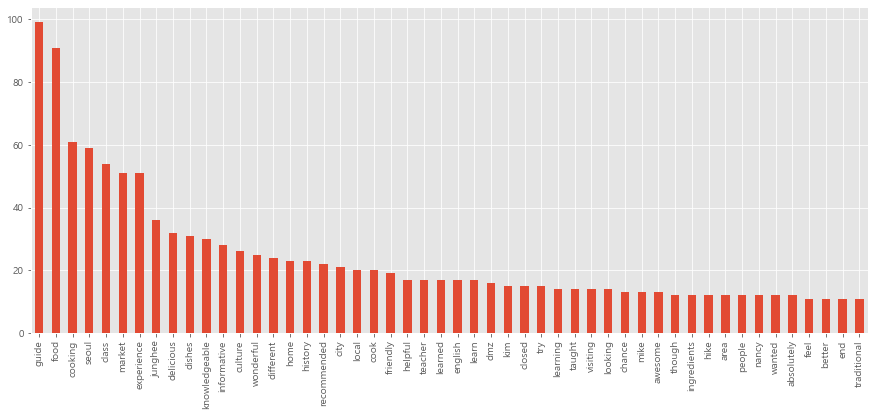

In [34]:
yearly_wordcount(positive_review, '2020')

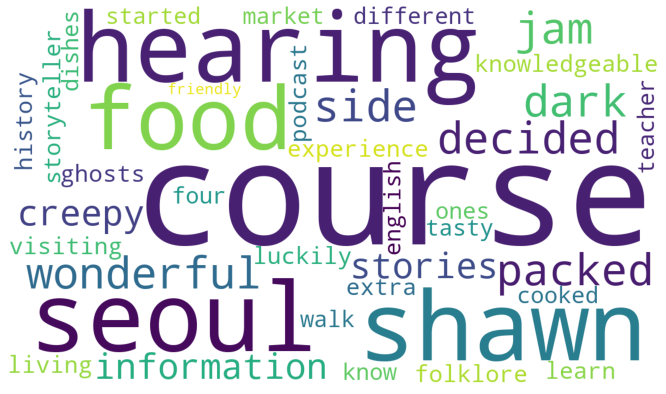

(None, <AxesSubplot:>)

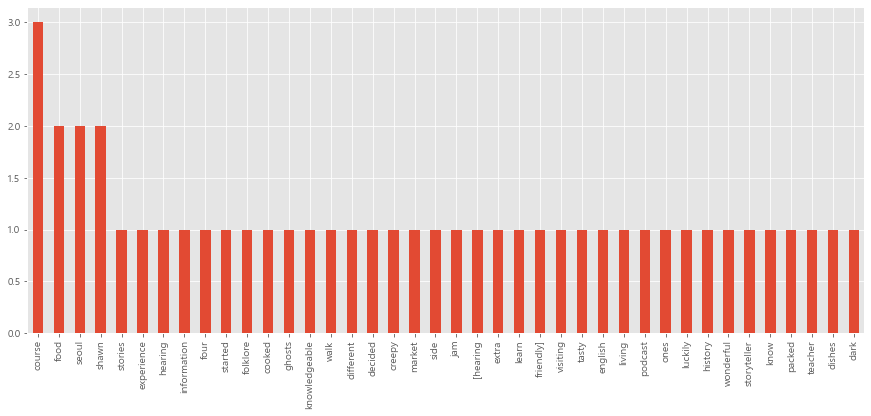

In [35]:
yearly_wordcount(positive_review, '2021')

#### Positive 리뷰텍스트 빈도

In [36]:
def topwords(data, year) :
    data = yearly_wordcount_data(data, year)
    data = re.sub('[^a-zA-Z]', ',', data).split(',')
    data = list(filter(None, data))
    data_count = pd.Series(data).value_counts().reset_index()
    data_count.columns = ['word','count']
    
    # 그 해의 리뷰에 사용된 단어 중 각 단어가 차지하는 비중
    data_count['ratio'] = data_count['count'] / np.sum(data_count['count'])*100
    data_count['year'] = year
    
    return data_count

In [37]:
# 19년 이전, 19년, 20년 이후로 데이터셋 분리
bef_19 = positive_review[positive_review['year'].isin(['2014','2015','2016','2017','2018'])]
aft_19 = positive_review[positive_review['year'].isin(['2019'])]
aft_covid = positive_review[positive_review['year'].isin(['2020','2021'])]

In [38]:
# 2014-2018년 리뷰 빈출단어 확인
bef_19_topwords = pd.DataFrame()
for i in range(2014, 2022):
    data = topwords(bef_19,str(i))
    bef_19_topwords = pd.concat([bef_19_topwords, data], axis = 0)
    bef_19_topwords = bef_19_topwords.groupby('word')[['word','count']].agg({'word':'max', 'count':'sum'})
    bef_19_topwords['ratio'] = round((bef_19_topwords['count'] / np.sum(bef_19_topwords['count']) * 100), 3)
bef_19_topwords.sort_values('count', ascending = False).reset_index(drop = True).head(20)

word  count  ratio
0           seoul    516  1.813
1           guide    490  1.721
2            food    306  1.075
3      experience    251  0.882
4         cooking    201  0.706
5           class    188  0.660
6         history    164  0.576
7          market    159  0.559
8          people    143  0.502
9           group    143  0.502
10        culture    123  0.432
11        english    123  0.432
12       friendly    120  0.422
13           city    119  0.418
14            rob    108  0.379
15  knowledgeable    108  0.379
16          local    107  0.376
17          lunch    105  0.369
18      different    105  0.369
19            dmz    104  0.365

In [39]:
# 2019년 리뷰 빈출단어 확인
aft_19_topwords = pd.DataFrame()
for i in range(2014, 2022):
    data = topwords(aft_19,str(i))
    aft_19_topwords = pd.concat([aft_19_topwords, data], axis = 0)
    aft_19_topwords = aft_19_topwords.groupby('word')[['word','count']].agg({'word':'max', 'count':'sum'})
    aft_19_topwords['ratio'] = round((aft_19_topwords['count'] / np.sum(aft_19_topwords['count']) * 100), 3)
aft_19_topwords.sort_values('count', ascending = False).reset_index(drop = True).head(20)

word  count  ratio
0           guide   1020  2.294
1           seoul    641  1.442
2            food    572  1.286
3      experience    425  0.956
4         history    356  0.801
5         cooking    282  0.634
6          market    261  0.587
7   knowledgeable    253  0.569
8           class    253  0.569
9        friendly    229  0.515
10          lunch    210  0.472
11          group    199  0.448
12            dmz    198  0.445
13        english    178  0.400
14           city    178  0.400
15          local    177  0.398
16         people    169  0.380
17        culture    166  0.373
18      wonderful    161  0.362
19    informative    159  0.358

In [40]:
# 2020-2021년 리뷰 빈출단어 확인
aft_covid_topwords = pd.DataFrame()
for i in range(2014, 2022):
    data = topwords(aft_covid,str(i))
    aft_covid_topwords = pd.concat([aft_covid_topwords, data], axis = 0)
    aft_covid_topwords = aft_covid_topwords.groupby('word')[['word','count']].agg({'word':'max', 'count':'sum'})
    aft_covid_topwords['ratio'] = round((aft_covid_topwords['count'] / np.sum(aft_covid_topwords['count']) * 100), 3)
aft_covid_topwords.sort_values('count', ascending = False).reset_index(drop = True).head(20)

word  count  ratio
0           guide    100  2.057
1            food     93  1.913
2         cooking     61  1.255
3           seoul     61  1.255
4           class     54  1.111
5      experience     52  1.070
6          market     52  1.070
7         junghee     36  0.741
8          dishes     32  0.658
9       delicious     32  0.658
10  knowledgeable     31  0.638
11    informative     28  0.576
12      wonderful     26  0.535
13        culture     26  0.535
14      different     25  0.514
15        history     24  0.494
16           home     23  0.473
17    recommended     22  0.453
18           city     21  0.432
19       friendly     20  0.411

In [41]:
bef_19_index = bef_19_topwords.sort_values(by = 'count', ascending = False).reset_index(drop = True).head(30)['word'].tolist()
aft_19_index = aft_19_topwords.sort_values(by = 'count', ascending = False).reset_index(drop = True).head(30)['word'].tolist()
aft_covid_index = aft_covid_topwords.sort_values(by = 'count', ascending = False).reset_index(drop = True).head(30)['word'].tolist()

In [42]:
common_topwords = set(bef_19_index) | set(aft_19_index) | set(aft_covid_index)

df_bef_19 = bef_19_topwords[bef_19_topwords['word'].isin(common_topwords)].reset_index(drop = True)
df_aft_19 = aft_19_topwords[aft_19_topwords['word'].isin(common_topwords)].reset_index(drop = True)
df_aft_covid = aft_covid_topwords[aft_covid_topwords['word'].isin(common_topwords)].reset_index(drop = True)

df_bef_19.columns = ['word', 'count_bef_19', 'ratio_bef_19']
df_aft_19.columns = ['word', 'count_aft_19', 'ratio_aft_19']
df_aft_covid.columns = ['word', 'count_aft_covid', 'ratio_aft_covid']

In [43]:
df = df_bef_19.merge(df_aft_19, how = 'outer', on = 'word').merge(df_aft_covid, how = 'outer', on = 'word').sort_values(
    by = 'ratio_aft_19', ascending = False).set_index('word').fillna(0)
df['count_bef_19'] = df['count_bef_19'].astype(int)
df['count_aft_covid'] = df['count_aft_covid'].astype(int)
df

count_bef_19  ratio_bef_19  count_aft_19  ratio_aft_19  \
word                                                                    
guide                   490         1.721          1020         2.294   
seoul                   516         1.813           641         1.442   
food                    306         1.075           572         1.286   
experience              251         0.882           425         0.956   
history                 164         0.576           356         0.801   
cooking                 201         0.706           282         0.634   
market                  159         0.559           261         0.587   
knowledgeable           108         0.379           253         0.569   
class                   188         0.660           253         0.569   
friendly                120         0.422           229         0.515   
lunch                   105         0.369           210         0.472   
group                   143         0.502           199         0.448   
dmz                     104         0.365           198         0.445   
english                 123         0.432           178         0.400   
city                    119         0.418           178         0.400   
local                   107         0.376           177         0.398   
people                  143         0.502           169         0.380   
culture                 123         0.432           166         0.373   
wonderful                81         0.285           161         0.362   
informative              65         0.228           159         0.358   
delicious                72         0.253           154         0.346   
hotel                    88         0.309           152         0.342   
jeju                     64         0.225           148         0.333   
different               105         0.369           141         0.317   
helpful                  70         0.246           140         0.315   
information              54         0.190           134         0.301   
beautiful                49         0.172           131         0.295   
bus                      72         0.253           129         0.290   
try                      53         0.186           122         0.274   
recommended              52         0.183           120         0.270   
dishes                   87         0.306           119         0.268   
traditional              91         0.320           109         0.245   
family                   80         0.281           108         0.243   
learn                    53         0.186            98         0.220   
kim                      36         0.126            89         0.200   
night                    77         0.270            89         0.200   
learned                  51         0.179            88         0.198   
tunnel                   80         0.281            85         0.191   
friends                  73         0.256            85         0.191   
private                  76         0.267            82         0.184   
home                     59         0.207            80         0.180   
cook                     30         0.105            57         0.128   
junghee                   0         0.000            46         0.103   
teacher                  28         0.098            27         0.061   
rob                     108         0.379            17         0.038   
minseon                  77         0.270            16         0.036   

               count_aft_covid  ratio_aft_covid  
word                                             
guide                      100            2.057  
seoul                       61            1.255  
food                        93            1.913  
experience                  52            1.070  
history                     24            0.494  
cooking                     61            1.255  
market                      52            1.070  
knowledgeable               31            0.638  
class     

In [44]:
df.style.background_gradient()

#### Negative review 결과 확인
- 2014~2016, 2021은 negative review 없음

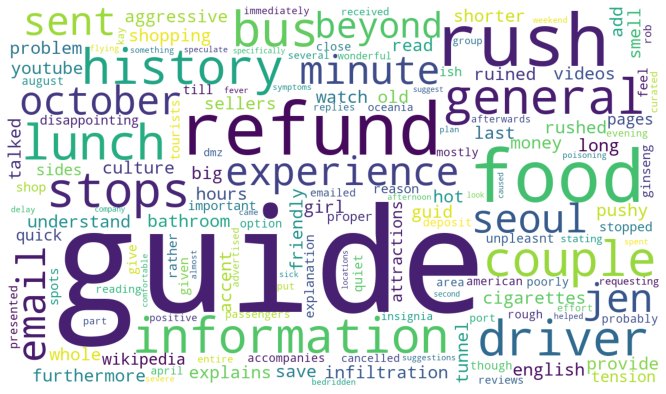

(None, <AxesSubplot:>)

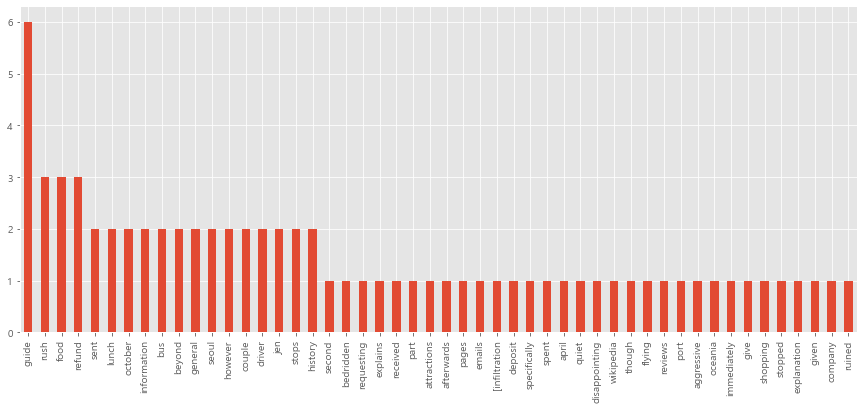

In [45]:
yearly_wordcount(negative_review, '2017')

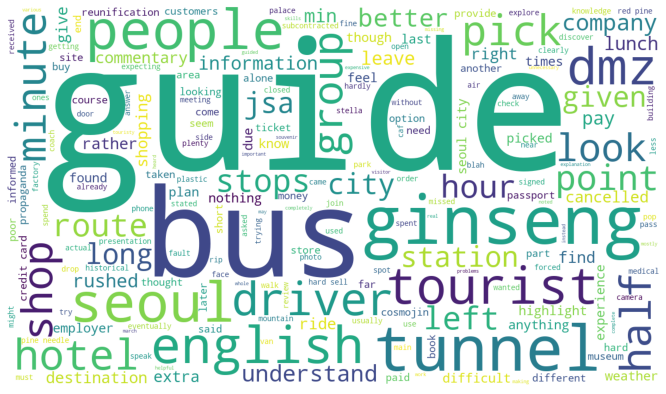

(None, <AxesSubplot:>)

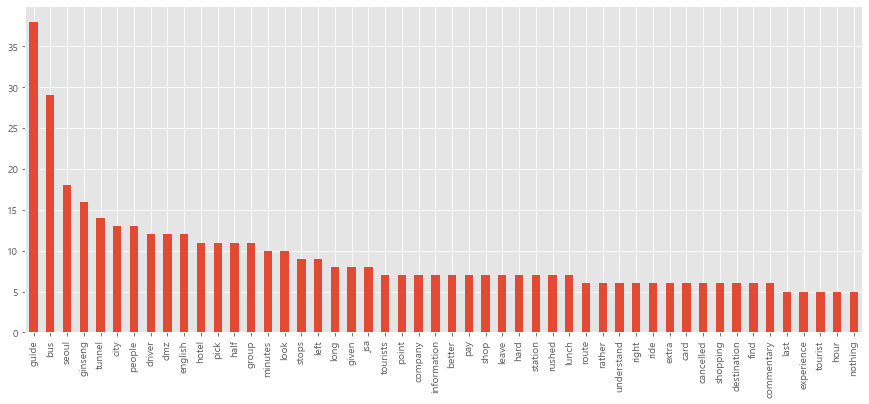

In [46]:
yearly_wordcount(negative_review, '2018')

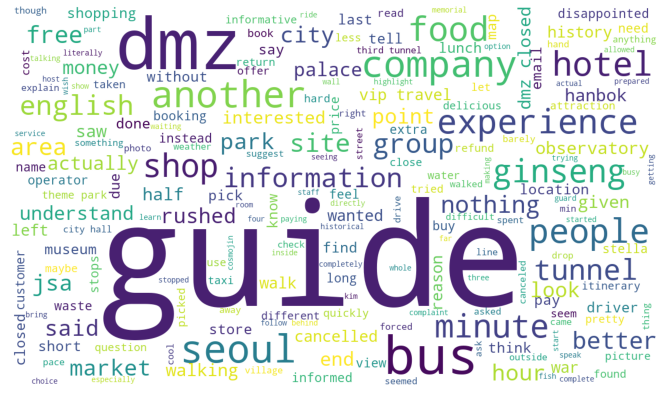

(None, <AxesSubplot:>)

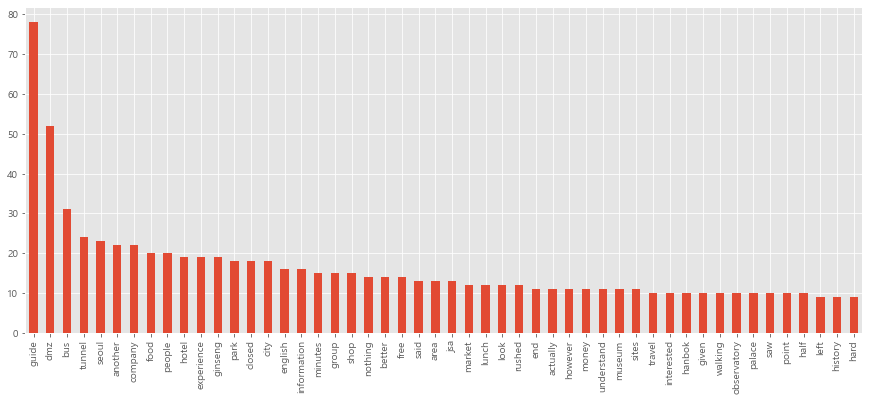

In [47]:
yearly_wordcount(negative_review, '2019')

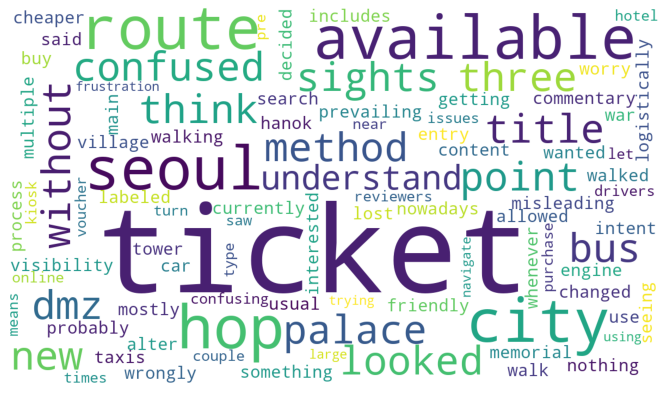

(None, <AxesSubplot:>)

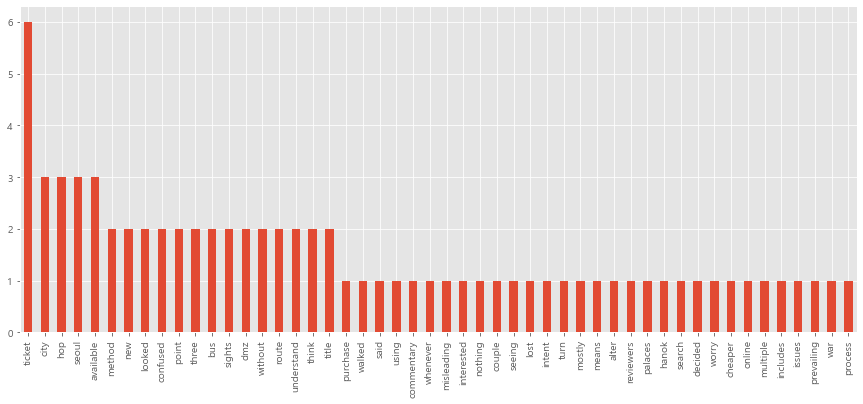

In [48]:
yearly_wordcount(negative_review, '2020')

#### Negative 리뷰텍스트 빈도

In [49]:
# 19년 이전, 19년, 20년 이후로 데이터셋 분리
df_bef_19 = negative_review[negative_review['year'].isin(['2017', '2018'])]
df_aft_19 = negative_review[negative_review['year'] == '2019']
df_aft_covid = negative_review[negative_review['year'] == '2020']

In [50]:
# 2017-2018년 리뷰 빈출단어 확인
bef_19_topwords = pd.DataFrame()
for i in range(2017, 2021):
    data = topwords(df_bef_19,str(i))
    bef_19_topwords = pd.concat([bef_19_topwords, data], axis = 0)
    bef_19_topwords = bef_19_topwords.groupby('word')[['word','count']].agg({'word':'max', 'count':'sum'})
    bef_19_topwords['ratio'] = round((bef_19_topwords['count'] / np.sum(bef_19_topwords['count']) * 100), 3)
bef_19_topwords.sort_values('count', ascending = False).reset_index(drop = True).head(20)

word  count  ratio
0         guide     45  2.046
1           bus     31  1.410
2         seoul     20  0.910
3       ginseng     17  0.773
4        tunnel     15  0.682
5        driver     14  0.637
6          city     13  0.591
7        people     13  0.591
8           dmz     13  0.591
9       english     13  0.591
10        group     12  0.546
11        stops     11  0.500
12        hotel     11  0.500
13         look     11  0.500
14         pick     11  0.500
15      minutes     11  0.500
16         half     11  0.500
17         left      9  0.409
18        given      9  0.409
19  information      9  0.409

In [51]:
# 2019년 리뷰 빈출단어 확인
aft_19_topwords = pd.DataFrame()
for i in range(2017, 2021):
    data = topwords(df_aft_19,str(i))
    aft_19_topwords = pd.concat([aft_19_topwords, data], axis = 0)
    aft_19_topwords = aft_19_topwords.groupby('word')[['word','count']].agg({'word':'max', 'count':'sum'})
    aft_19_topwords['ratio'] = round((aft_19_topwords['count'] / np.sum(aft_19_topwords['count']) * 100), 3)
aft_19_topwords.sort_values('count', ascending = False).reset_index(drop = True).head(20)

word  count  ratio
0         guide     78  2.213
1           dmz     52  1.475
2           bus     31  0.879
3        tunnel     24  0.681
4         seoul     23  0.652
5       another     22  0.624
6       company     22  0.624
7        people     20  0.567
8          food     20  0.567
9    experience     19  0.539
10      ginseng     19  0.539
11        hotel     19  0.539
12         city     18  0.511
13       closed     18  0.511
14         park     18  0.511
15  information     16  0.454
16      english     16  0.454
17      minutes     15  0.426
18        group     15  0.426
19         shop     15  0.426

In [52]:
# 2020년 리뷰 빈출단어 확인
aft_covid_topwords = pd.DataFrame()
for i in range(2017, 2021):
    data = topwords(df_aft_covid,str(i))
    aft_covid_topwords = pd.concat([aft_covid_topwords, data], axis = 0)
    aft_covid_topwords = aft_covid_topwords.groupby('word')[['word','count']].agg({'word':'max', 'count':'sum'})
    aft_covid_topwords['ratio'] = round((aft_covid_topwords['count'] / np.sum(aft_covid_topwords['count']) * 100), 3)
aft_covid_topwords.sort_values('count', ascending = False).reset_index(drop = True).head(20)

word  count  ratio
0       ticket      6  4.918
1          hop      3  2.459
2    available      3  2.459
3        seoul      3  2.459
4         city      3  2.459
5          dmz      2  1.639
6        route      2  1.639
7       method      2  1.639
8       looked      2  1.639
9       sights      2  1.639
10       think      2  1.639
11       three      2  1.639
12       title      2  1.639
13  understand      2  1.639
14         new      2  1.639
15       point      2  1.639
16     without      2  1.639
17    confused      2  1.639
18         bus      2  1.639
19       worry      1  0.820

In [53]:
df_bef_19_index = bef_19_topwords.sort_values(by = 'count', ascending = False).reset_index(drop = True).head(30)['word'].tolist()
df_aft_19_index = aft_19_topwords.sort_values(by = 'count', ascending = False).reset_index(drop = True).head(30)['word'].tolist()
df_aft_covid_index = aft_covid_topwords.sort_values(by = 'count', ascending = False).reset_index(drop = True).head(30)['word'].tolist()

In [54]:
neg_common_topwords = set(df_bef_19_index) | set(df_aft_19_index) | set(df_aft_covid_index)

df_bef_19 = bef_19_topwords[bef_19_topwords['word'].isin(neg_common_topwords)].reset_index(drop = True)
df_aft_19 = aft_19_topwords[aft_19_topwords['word'].isin(neg_common_topwords)].reset_index(drop = True)
df_aft_covid = aft_covid_topwords[aft_covid_topwords['word'].isin(neg_common_topwords)].reset_index(drop = True)

df_bef_19.columns = ['word', 'count_bef_19', 'ratio_bef_19']
df_aft_19.columns = ['word', 'count_aft_19', 'ratio_aft_19']
df_aft_covid.columns = ['word', 'count_aft_covid', 'ratio_aft_covid']

In [55]:
df_neg = df_bef_19.merge(df_aft_19, how = 'outer', on = 'word').merge(df_aft_covid, how = 'outer', on = 'word').sort_values(
    by = 'ratio_aft_19', ascending = False).set_index('word').fillna(0)
df_neg['count_bef_19'] = df_neg['count_bef_19'].astype(int)
df_neg['count_aft_19'] = df_neg['count_aft_19'].astype(int)
df_neg['count_aft_covid'] = df_neg['count_aft_covid'].astype(int)
df_neg

count_bef_19  ratio_bef_19  count_aft_19  ratio_aft_19  \
word                                                                
guide                45         2.046            78         2.213   
dmz                  13         0.591            52         1.475   
bus                  31         1.410            31         0.879   
tunnel               15         0.682            24         0.681   
seoul                20         0.910            23         0.652   
...                 ...           ...           ...           ...   
reviewers             0         0.000             0         0.000   
search                0         0.000             0         0.000   
sights                0         0.000             0         0.000   
title                 0         0.000             0         0.000   
worry                 0         0.000             0         0.000   

           count_aft_covid  ratio_aft_covid  
word                                         
guide                    0            0.000  
dmz                      2            1.639  
bus                      2            1.639  
tunnel                   0            0.000  
seoul                    3            2.459  
...                    ...              ...  
reviewers                1            0.820  
search                   1            0.820  
sights                   2            1.639  
title                    2            1.639  
worry                    1            0.820  

[64 rows x 6 columns]

In [56]:
df_neg.style.background_gradient()